In [10]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os
import torch as pt
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
from src.isokann.modules import *

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# For reproducibility
np.random.seed(0)
pt.manual_seed(0)

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print("")
print(device)


Created variables:
inp_dir = input/
out_trajectories1 = output/trajectories/
out_trajectories2 = output/trajectories/openmm_files/
out_trajectories3 = output/trajectories/openmm_files/initial_states/
out_trajectories4 = output/trajectories/openmm_files/final_states/
out_isokann = output/isokann/
out_mokito = output/mokito/

cuda


In [11]:
# Load initial and final states and convert to torch
D0 = pt.load(out_trajectories1 + 'PWDistances_0.pt', map_location=device)
DT = pt.load(out_trajectories1 + 'PWDistances_t.pt', map_location=device)
R0 = np.loadtxt(out_trajectories1 + 'R0.txt')

Npoints = D0.shape[0]
Ndims   = D0.shape[1]

Nfinpoints  = DT.shape[1]
Nframes     = DT.shape[3]


frame = 0
Dt = pt.clone(DT[frame,:,:,:])

In [12]:
# Find the optimal hyperparameters using random search
NN_layers =          [(Ndims, int(2*Ndims/3), 1), 
                      (Ndims, int(Ndims/2), 1), 
                      (Ndims, int(Ndims/3), 1)]


learning_rates = [0.01, 
                  0.001, 
                  0.0001]

weight_decays = [0.001, 0.0001, 0.00001]

best_hyperparams, best_val_loss = random_search(D0, Dt, 
                                                NN_layers, 
                                                learning_rates, 
                                                weight_decays, 
                                                batch_size = 200,
                                                search_iterations=5)

print(" ")
print("The best hyperparameters are:", best_hyperparams)
print("The best validation loss is:",  best_val_loss)
print(" ")

  0%|          | 0/5 [00:00<?, ?it/s]

Testing learning rate = 0.01
Testing weight decays = 0.0001
Testing layers = [66 44  1]


 20%|██        | 1/5 [01:06<04:27, 66.79s/it]

Validation loss: tensor(0.0008, device='cuda:0')
Testing learning rate = 0.001
Testing weight decays = 1e-05
Testing layers = [66 33  1]


 40%|████      | 2/5 [02:05<03:05, 61.80s/it]

Validation loss: tensor(0.0008, device='cuda:0')
Testing learning rate = 0.0001
Testing weight decays = 1e-05
Testing layers = [66 44  1]


 60%|██████    | 3/5 [03:51<02:44, 82.22s/it]

Validation loss: tensor(0.0008, device='cuda:0')
Testing learning rate = 0.01
Testing weight decays = 1e-05
Testing layers = [66 33  1]


 80%|████████  | 4/5 [05:05<01:19, 79.06s/it]

Validation loss: tensor(0.0036, device='cuda:0')
Testing learning rate = 0.01
Testing weight decays = 0.001
Testing layers = [66 22  1]


100%|██████████| 5/5 [06:22<00:00, 76.60s/it]

Validation loss: tensor(0.0012, device='cuda:0')
 
The best hyperparameters are: {'nodes': array([66, 33,  1]), 'learning_rate': 0.001, 'weight_decay': 1e-05}
The best validation loss is: tensor(0.0008, device='cuda:0')
 


In [13]:
# The best hyperparameters are: {'nodes': array([66, 33,  1]), 'learning_rate': 0.001, 'weight_decay': 1e-05}
NNnodes = best_hyperparams['nodes']
print("FNN layers:", NNnodes)

lr      = best_hyperparams['learning_rate']
print("lr = ", lr)

wd = best_hyperparams['weight_decay']
print("wd = ", wd)

np.savetxt(out_isokann + 'NNnodes.txt', NNnodes)

# Define the interpolating function
f_NN = NeuralNetwork( Nodes = np.asarray(NNnodes) ).to(device)

# Apply the power method using the best hyperparameters
train_LOSS, val_LOSS, best_loss = power_method(D0, Dt, 
                                               f_NN, 
                                               scale_and_shift, 
                                               Niters = 200, 
                                               Nepochs = 100,
                                               tolerance  = 5e-4, 
                                               lr = lr,
                                               wd=wd,
                                               batch_size = 100,  
                                               print_eta  = True
                                              )

FNN layers: [66 33  1]
lr =  0.001
wd =  1e-05


100%|██████████| 200/200 [02:51<00:00,  1.17it/s]


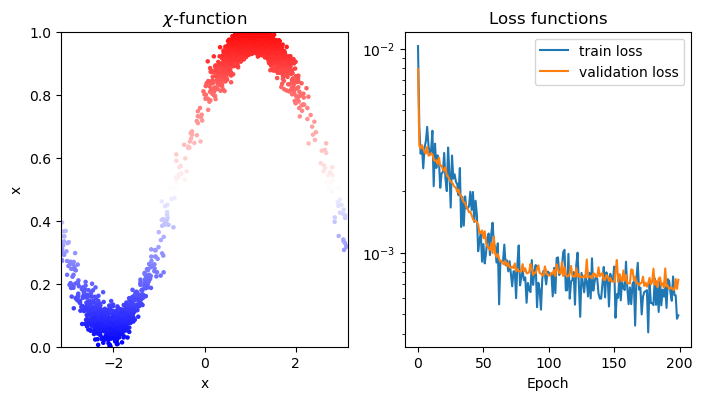

In [15]:
npX0 = D0.cpu().detach().numpy()
chi  = f_NN(D0).cpu().detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(16*in2cm, 8*in2cm), facecolor='white')


pos = ax[0].scatter( R0, chi, c = chi,  cmap = cm.bwr , s = 5 )

ax[0].set_title('$\chi$-function')
ax[0].set_ylim((0,1))
ax[0].set_xlim((-3.14,3.14))
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'$\chi$')


ax[1].plot(train_LOSS, label='train loss')
ax[1].plot(val_LOSS, label='validation loss')
ax[1].semilogy()
ax[1].set_xlabel('Epoch')
ax[1].set_title('Loss functions')
ax[1].legend()

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)
#fig.savefig('chi.png', format='png', dpi=900, bbox_inches='tight')

In [17]:
pt.save(f_NN.state_dict(), out_isokann  + 'f_NN.pt')
np.savetxt(out_isokann  + 'val_LOSS.txt', val_LOSS)
np.savetxt(out_isokann  + 'train_LOSS.txt', train_LOSS)
np.save(out_isokann + 'chi0.npy', chi)

# Calculate propagated chi
#chit = f_NN(Xtau).cpu().detach().numpy()
#np.save(out_isokann + 'chit.npy', chit)
